In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import torch
import warnings
import numpy as np
import matplotlib.pyplot as plt
from toolz.curried import pipe, curry, compose, memoize

In [3]:
import chnet.cahn_hill as ch

In [4]:
def draw_im(im, title=None):
    im = np.squeeze(im)
    plt.imshow(im)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()
    
    
def rmserror(x, y):
    return np.sqrt(np.mean((x - y)**2))

### Generate random data

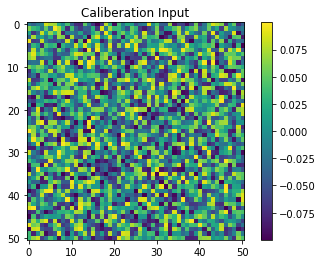

CPU times: user 134 ms, sys: 4.57 ms, total: 139 ms
Wall time: 138 ms


In [5]:
%%time
N = 51
n_samples = 10
x_data = (2 * np.random.random((n_samples, N, N)) - 1) * 0.1
draw_im(x_data[0], "Caliberation Input")

## Simulation Time Steps

In [6]:
sim_steps = 100

## PyMKS solver

In [7]:
%%time
y_data1 = x_data.copy()
for i in range(sim_steps):
    y_data1 = ch.ch_run(y_data1, dt = 0.001)

CPU times: user 19 s, sys: 681 ms, total: 19.7 s
Wall time: 953 ms


## PyTorch CPU solver

In [8]:
%%time
device = torch.device("cpu")
y_data2 = ch.ch_run_torch(x_data.copy(), dt = 0.001, sim_step=sim_steps, device=device)

CPU times: user 4.33 s, sys: 109 ms, total: 4.44 s
Wall time: 214 ms


### Check closeness of data with PyMKS results(Ground Truth)

In [9]:
np.allclose(y_data1, y_data2)

True

## Pytorch GPU solver

In [10]:
%%time
device=torch.device("cuda:0")
y_data3 = ch.ch_run_torch(x_data.copy(), dt = 0.001, sim_step=sim_steps, device=device)

CPU times: user 5.31 s, sys: 1.11 s, total: 6.41 s
Wall time: 3.11 s


### Check closeness of data with PyMKS results(Ground Truth)

In [11]:
np.allclose(y_data1, y_data3)

True

## Visualize Results

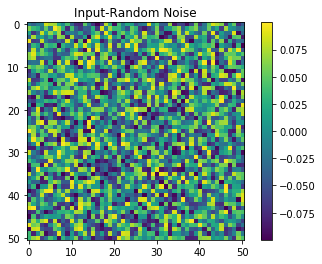

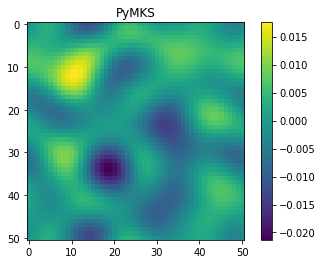

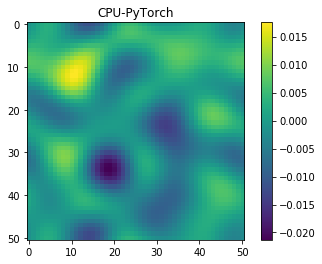

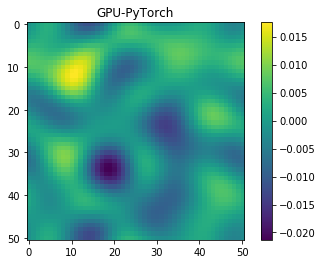

check for rmserror

PyMKS-ptCPU 1.1950073287125713e-15
PyMKS-ptGPU 1.204558930224234e-15

check for mass conservation

0.0003941129012556131
0.0003941129012556349
0.0003941129012556131
0.0003941129012556129


In [12]:
draw_im(x_data[0], "Input-Random Noise")
draw_im(y_data1[0], "PyMKS")
draw_im(y_data2[0], "CPU-PyTorch")
draw_im(y_data3[0], "GPU-PyTorch")

print("check for rmserror\n")
print("PyMKS-ptCPU", rmserror(y_data1, y_data2))
print("PyMKS-ptGPU", rmserror(y_data1, y_data3))
print()
print("check for mass conservation\n")
print(np.mean(x_data))
print(np.mean(y_data1))
print(np.mean(y_data2))
print(np.mean(y_data3))

## Measure of CPU to GPU data transit latencies

In [13]:
def transit_time(N = 10, ndim=3, device=torch.device("cuda:0"), nstep = 5):
    
    elpsd = []
    for i in range(nstep):
        x = torch.zeros([N]*ndim)
        start = time.time()
        x.to(device)
        y = x.cpu().numpy()
        elpsd.append(time.time() - start)
    return elpsd

In [14]:
%%time
print(np.mean(transit_time(N=10, nstep = 10)[1:]))
print(np.mean(transit_time(N=100, nstep = 10)[1:]))
print(np.mean(transit_time(N=500, nstep = 10)[1:]))
print(np.mean(transit_time(N=1000, nstep = 10)[1:]))

1.6450881958007812e-05
0.0006191465589735243
0.0633588367038303
0.5302972793579102
CPU times: user 1min 6s, sys: 12.8 s, total: 1min 19s
Wall time: 6.97 s
